In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Các thư viện sử dụng

In [ ]:
# common library
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# import glob
# from google.colab.patches import cv2_imshow

# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


In [ ]:
# change path
import os
os.chdir('/content/drive/MyDrive/VietNam SignLanguage')
print(os.getcwd())

/content/drive/MyDrive/VietNam SignLanguage


# Các tham số toàn cục

In [ ]:
# some global params
SIZE = (128, 128)

# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 100
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'

# Các hàm phụ trợ

## Tiền xử lý

In [ ]:
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized



In [ ]:
def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

## Đọc dữ liệu và mã hóa nhãn dữ liệu

In [ ]:
def readFramesThread(sema, x_data, y_data, word, path, dsize):
  sema.acquire()

  frames = os.listdir(path)
  lframes = []

  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = preprocessingImg(img, dsize)
    lframes.append(img)

  x_data.append(lframes) # add video into list
  y_data.append(word) # add label

  # time.sleep(0.2)
  sema.release()


def readDataThread(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  maxthreads = NUM_THREADS
  sema = threading.Semaphore(value=maxthreads) # sema type
  threads = list()

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    print(reader)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]

      if (listWord != None) and (word not in listWord): # decrease num classes
        continue

      # print(video)
      path = os.path.join(input_path, video)
      # execute thread
      thread = threading.Thread( target=readFramesThread, args=(sema, x_data, y_data, word, path, dsize) )
      threads.append(thread)
      thread.start()

    for t in threads: # for waiting all thread end
      t.join()

  return x_data, y_data


In [ ]:
def readFrames(path, dsize):
  frames = os.listdir(path)
  lframes = []

  for frame in frames: # read all frames in video
    frame_path = os.path.join(path, frame)
    img = cv2.imread(frame_path, 1)
    img = resizeImage(img, dsize)
    lframes.append(img)

  return lframes

def readData(input_path, csv_file, dsize=(128,128), listWord = None):
  x_data = []
  y_data = []

  with open(csv_file) as csvfile: # read path from csv
    reader = csv.reader(csvfile)
    for row in reader:
      # video path
      video = row[0]
      word = video.split('/')[0]
      # if (listWord != None) and (word not in listWord): # decrease num classes
      #   continue

      print(video)
      path = os.path.join(input_path, video)
      lframes = readFrames(path, dsize)

      x_data.append(lframes) # add video into list
      y_data.append(word) # add label

  return x_data, y_data

In [ ]:

#encoder label to train in model
def encoderLabel(y_train, y_test, classes_file = 'classes.npy', save = True):
  encoder = LabelEncoder()
  encoder.fit(y_train)

  # save classes, save as numpy array
  if save == True:
    np.save(classes_file, encoder.classes_)

  # encoder to number
  y_train1 = encoder.fit_transform(y_train)
  y_test1 = encoder.fit_transform(y_test)
  # [a,c, y,a ] -> [1,2,3,1]
  num_classes=len(np.unique(y_train))
  #encoder to binary matrix
  y_train2 = to_categorical(y_train1, num_classes=len(np.unique(y_train)))
  y_test2 = to_categorical(y_test1, num_classes=len(np.unique(y_test)))

  return y_train2, y_test2, num_classes

# Main

## Đọc dữ liệu và tiền xử lý

In [ ]:

start = time.time()

train_path = "/content/drive/MyDrive/VietNam SignLanguage/Data_Aug_3/train_dir_2"
train_csv = '/content/drive/MyDrive/VietNam SignLanguage/Data_Aug_3/train_dir_2_new.csv'


# x_train_o, y_train_o = readDataThread(train_path, train_csv, SIZE, listWord)
x_train_o, y_train_o = readDataThread(train_path, train_csv, SIZE)
end = time.time()
print('time:', end - start)

time: 63.51029181480408


In [ ]:

start = time.time()

test_path = '/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/val_dir'
test_csv = '/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/val_2.csv'

# x_test_o, y_test_o = readDataThread(test_path, test_csv, SIZE, listWord)
x_test_o, y_test_o = readDataThread(test_path, test_csv, SIZE)

end = time.time()
print('time:', end - start)

time: 2.6535894870758057


In [ ]:
# convert to numpy array
x_train = np.array(x_train_o)
x_val = np.array(x_test_o)
y_train = np.array(y_train_o)
y_val = np.array(y_test_o)
print('x_train shape', x_train.shape) # (400, 10, 128, 128, 3) max 2560
print('y_train shape', y_train.shape) # (400,)
print('x_val shape', x_val.shape) # (100, 10, 128, 128, 3) max 640
print('y_val shape', y_val.shape) # (100,)

convert = False
if convert == True:
  n, nb, h, w, c = x_train.shape
  x_train= x_train.reshape(n, nb, h*w*c)
  n, nb, h, w, c = x_val.shape
  x_test= x_val.reshape(n, nb, h*w*c)

  print('x_train shape', x_train.shape) # (400, 10, 223) max 2560
  print('y_train shape', y_train.shape) # (400,)
  print('x_val shape', x_val.shape) # (100, 10, 128, 128, 3) max 640
  print('y_val shape', y_val.shape) # (100,)

x_train shape (794, 10, 128, 128, 3)
y_train shape (794,)
x_val shape (50, 10, 128, 128, 3)
y_val shape (50,)


In [ ]:
x_train = x_train /255.
x_val = x_val / 255.

## Mã hóa nhãn dữ liệu

In [ ]:
listclasses =  np.unique(y_train)
num_classes = len(listclasses)
print(num_classes)
print(listclasses)

y_train_decode, y_val_decode, num_classes = encoderLabel(y_train, y_val)

print(y_train_decode.shape)
print(y_val_decode.shape)

5
['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
(794, 5)
(50, 5)


# Mô hình

# VGG16

## Kiến trúc mô hình

In [ ]:
def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_VGG16_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Create Model
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# INSHAPE= ( NBFRAME, SIZE[0] * SIZE[1] * CHANNELS)  # (5, 128 * 128 * 3)
print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.summary()

(10, 128, 128, 3)
Model loaded..!
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 512)           14714688  
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 10, 64)            147712    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           394240    
                                                                 
 lstm_3 (LSTM)               (None, 64)                82176     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

## Khởi tạo và huấn luyện

In [ ]:
tic = time.time()

EPOCHS = 55
# early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
# save_checkpoint = ModelCheckpoint('chkp/best-weights-giang.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
# csv_logger = CSVLogger('chkp/training-lstm.csv', separator=",", append=False) # dùng pandas đọc
# # reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

# callbacks = [early_stoping,
#              save_checkpoint,
#              csv_logger,
#             #  reduce_lr
#              ]
# history = model.fit_generator(train,validation_data=valid,verbose=1,epochs=EPOCHS,callbacks=callbacks)
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_val, y_val_decode),
            verbose=1,
            # callbacks=callbacks
           )

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/55
40/40 [==============================] - 124s 2s/step - loss: 1.6094 - accuracy: 0.2103 - val_loss: 1.6095 - val_accuracy: 0.1400
Epoch 2/55
40/40 [==============================] - 35s 881ms/step - loss: 1.6081 - accuracy: 0.2141 - val_loss: 1.6093 - val_accuracy: 0.2000
Epoch 3/55
40/40 [==============================] - 35s 873ms/step - loss: 1.6098 - accuracy: 0.2040 - val_loss: 1.6090 - val_accuracy: 0.1800
Epoch 4/55
40/40 [==============================] - 35s 870ms/step - loss: 1.6094 - accuracy: 0.2103 - val_loss: 1.6087 - val_accuracy: 0.2000
Epoch 5/55
11/40 [=======>......................] - ETA: 24s - loss: 1.6086 - accuracy: 0.1682

## Lịch sử huấn luyện

In [ ]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-VGG16_Aug.keras")

#MobileNet #


## Kiến trúc mô hình

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from tensorflow.data import Iterator
from tensorflow.python.framework import graph_util

from tensorflow.keras.applications import MobileNetV2

import tensorflow.keras.layers as layers


In [ ]:
def load_MobileNet_model(shape=(112, 112, 3)):
  base_model =  MobileNetV2(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_MobileNet_model(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Create Model
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# INSHAPE= ( NBFRAME, SIZE[0] * SIZE[1] * CHANNELS)  # (5, 128 * 128 * 3)
print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.summary()

(10, 128, 128, 3)
9406464/9406464 [==============================] - 0s 0us/step
Model loaded..!
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDi  (None, 10, 1280)          2257984   
 stributed)                                                      
                                                                 
 lstm_8 (LSTM)               (None, 10, 64)            344320    
                                                                 
 lstm_9 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_10 (LSTM)              (None, 10, 256)           394240    
                                                                 
 lstm_11 (LSTM)              (None, 64)                82176     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                      

## Khởi tạo và huấn luyện

In [ ]:
tic = time.time()

EPOCHS = 55
# 100
early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
# save_checkpoint = ModelCheckpoint('chkp/best-weights-giang.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
# csv_logger = CSVLogger('chkp/training-lstm.csv', separator=",", append=False) # dùng pandas đọc
# # reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

# callbacks = [early_stoping,
#              save_checkpoint,
#              csv_logger,
#             #  reduce_lr
#              ]
# history = model.fit_generator(train,validation_data=valid,verbose=1,epochs=EPOCHS,callbacks=callbacks)
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_val, y_val_decode),
            verbose=1,
            # callbacks=callbacks
           )
toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/55
40/40 [==============================] - 47s 519ms/step - loss: 1.6558 - accuracy: 0.1826 - val_loss: 1.6421 - val_accuracy: 0.2200
Epoch 2/55
40/40 [==============================] - 15s 363ms/step - loss: 1.6200 - accuracy: 0.2078 - val_loss: 1.6803 - val_accuracy: 0.2000
Epoch 3/55
40/40 [==============================] - 14s 362ms/step - loss: 1.6144 - accuracy: 0.2028 - val_loss: 1.6369 - val_accuracy: 0.2200
Epoch 4/55
40/40 [==============================] - 14s 360ms/step - loss: 1.6066 - accuracy: 0.2355 - val_loss: 1.6271 - val_accuracy: 0.2400
Epoch 5/55
40/40 [==============================] - 15s 363ms/step - loss: 1.6091 - accuracy: 0.2053 - val_loss: 1.6028 - val_accuracy: 0.2400
Epoch 6/55
40/40 [==============================] - 14s 361ms/step - loss: 1.6025 - accuracy: 0.2116 - val_loss: 1.6000 - val_accuracy: 0.2400
Epoch 7/55
40/40 [==============================] - 14s 362ms/step - loss: 1.5881 - accuracy: 0.2506 - val_loss: 1.5998 - val_accuracy: 0.2400

## Lịch sử huấn luyện

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


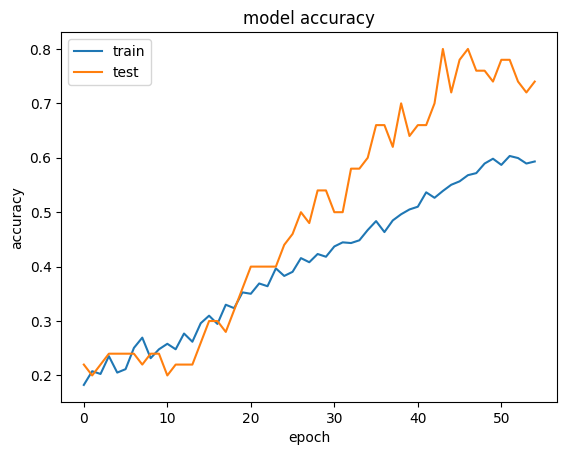

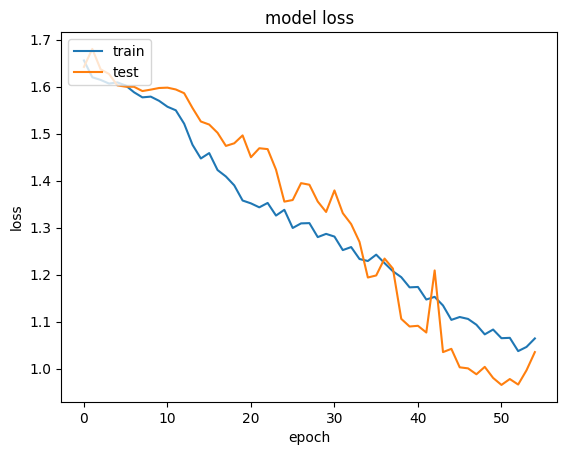

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-MobileNet_Aug.keras")

# ResNet50

## Kiến trúc mô hình

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
from tensorflow.data import Iterator
from tensorflow.python.framework import graph_util

from tensorflow.keras.applications import ResNet50

import tensorflow.keras.layers as layers


In [ ]:
def load_ResNet50_model(shape=(112, 112, 3)):
  base_model =  ResNet50(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_ResNet50_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
#Create Model
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
# INSHAPE= ( NBFRAME, SIZE[0] * SIZE[1] * CHANNELS)  # (5, 128 * 128 * 3)
print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.summary()

(10, 128, 128, 3)
Model loaded..!
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                     

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 10, 2048)          23587712  
 stributed)                                                      
                                                                 
 lstm_24 (LSTM)              (None, 10, 64)            540928    
                                                                 
 lstm_25 (LSTM)              (None, 10, 128)           98816     
                                                                 
 lstm_26 (LSTM)              (None, 10, 256)           394240    
                                                                 
 lstm_27 (LSTM)              (None, 64)                82176     
                                                                 
 dense_17 (Dense)            (None, 64)                4160      
                                                     

## Khởi tạo và huấn luyện

In [ ]:
tic = time.time()

EPOCHS = 55
# early_stoping = EarlyStopping(monitor='val_accuracy', patience=9, verbose=1, mode='max')
# save_checkpoint = ModelCheckpoint('chkp/best-weights-giang.hdf5', monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True, mode='max')
# csv_logger = CSVLogger('chkp/training-lstm.csv', separator=",", append=False) # dùng pandas đọc
# # reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 1, min_lr = 1e-8, verbose=1)

# callbacks = [early_stoping,
#              save_checkpoint,
#              csv_logger,
#             #  reduce_lr
#              ]
# history = model.fit_generator(train,validation_data=valid,verbose=1,epochs=EPOCHS,callbacks=callbacks)
history = model.fit(x_train, y_train_decode,
            epochs=EPOCHS,
            batch_size=BS,
            shuffle=True,
            validation_data = (x_val, y_val_decode),
            verbose=1,
            # callbacks=callbacks
           )

toc = time.time()
print("TRAINING TIME: ", toc-tic)

Epoch 1/55
40/40 [==============================] - 59s 852ms/step - loss: 1.6651 - accuracy: 0.2267 - val_loss: 1.5911 - val_accuracy: 0.1800
Epoch 2/55
40/40 [==============================] - 32s 806ms/step - loss: 1.6200 - accuracy: 0.2217 - val_loss: 1.6086 - val_accuracy: 0.2200
Epoch 3/55
40/40 [==============================] - 32s 810ms/step - loss: 1.6050 - accuracy: 0.2191 - val_loss: 1.5909 - val_accuracy: 0.1600
Epoch 4/55
40/40 [==============================] - 33s 822ms/step - loss: 1.6092 - accuracy: 0.1940 - val_loss: 1.5964 - val_accuracy: 0.2800
Epoch 5/55
40/40 [==============================] - 33s 830ms/step - loss: 1.6022 - accuracy: 0.2053 - val_loss: 1.5857 - val_accuracy: 0.2000
Epoch 6/55
40/40 [==============================] - 33s 836ms/step - loss: 1.5748 - accuracy: 0.2456 - val_loss: 1.5611 - val_accuracy: 0.2600
Epoch 7/55
40/40 [==============================] - 34s 838ms/step - loss: 1.5728 - accuracy: 0.2355 - val_loss: 1.6020 - val_accuracy: 0.2800

## Lịch sử huấn luyện

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


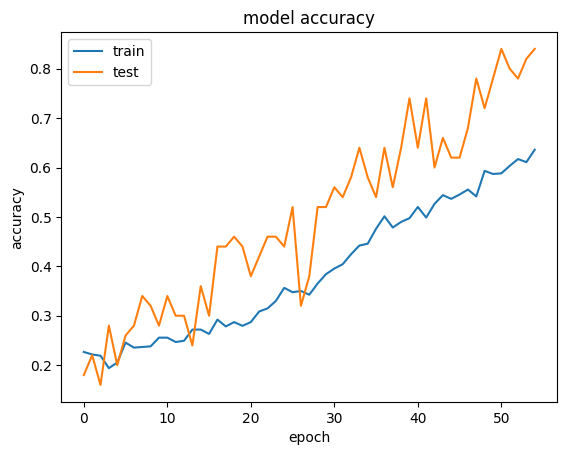

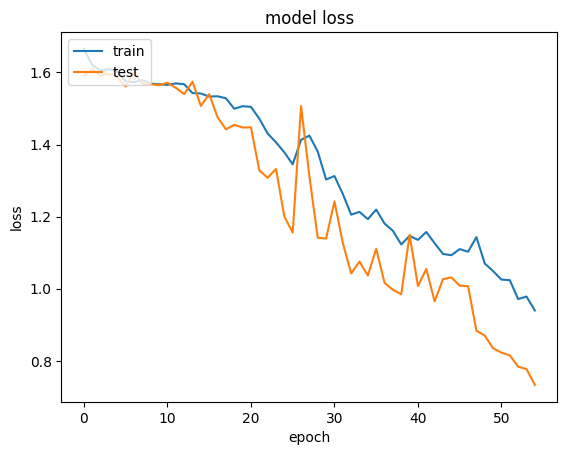

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/VietNam SignLanguage/LSTM-ResNet50_Aug.keras")

# Kiểm thử mô hình

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_fscore_support
# common library
import numpy as np
import os
import time
import cv2
import matplotlib.pyplot as plt


# tensorflow library
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, SimpleRNN
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, MaxPooling2D
# from keras.layers import TimeDistributed, GRU, Dense, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

from keras.applications.vgg16 import VGG16

# reading data
import csv
import threading

# Label encoder
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# some global params
SIZE = (128,128)
# SIZE = (64,64)
# SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 10
BS = 20

NUM_THREADS = 8

#preprocessing
LENGTH_TRIM = 130


In [ ]:
# resize image by dsize = (128, 128)
def resizeImage(img, dsize):
  sizeImg = (img.shape[0],img.shape[1])
  if sizeImg != dsize and dsize != (None, None):
    img = cv2.resize(img,dsize)
  return img

# remove left right background
def removeTrimBackground(img, length = 120):
  img = img[:,length:-1*length]
  return img

def resizeScale(img, scale = 30):
  scale_percent = scale # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)

  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return resized

def preprocessingImg(img, dsize = (128,128)):
  # img = human_detection(img)
  img = removeTrimBackground(img, LENGTH_TRIM)
  img = resizeImage(img, dsize)
  return img

In [ ]:

def predictVideoOneTime(paths, classes, model, verbose=0):
    data = []
    names = []
    expecteds = []
    n = len(paths)
    for path in paths:
        myVideo = MyVideo(path)
        item = preprocessingVideo(myVideo)
        data.append(item)
        names.append(myVideo.getFileName())
        expecteds.append(myVideo.getLabel())

    data = np.array(data)
    predicted = np.argmax(model.predict(data), axis=-1)

    dic = {}
    count = 0
    y_true = []
    y_pred = []
    for i in range(n):
        expected = expecteds[i].split('\\')[1]
        text = 'Video: ' + names[i] + ' Expected: ' + expected + ' Predicted: ' + classes[predicted[i]]
        if expected not in dic:
            dic[expected] = 0
        if expected == classes[predicted[i]]:
            count = count + 1
            dic[expected] = dic[expected] + 1
        else:
            text = '\x1b[31m' + text + '\x1b[0m'
        if verbose == 1:
            print(text)
        y_true.append(expected)
        y_pred.append(classes[predicted[i]])

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1score = f1_score(y_true, y_pred, average='weighted')

    print()
    print('Accuracy:', str(count) + '/' + str(n), ',', str(count / n))
    print('Precision:', precision)
    print('Recall Score:', recall)
    print('F1 Score:', f1score)
    return dic, precision, recall, f1score
def predictVideoOneByOne(paths, classes, verbose=0):
    dic = {}
    y_true = []
    y_pred = []

    count = 0
    n = len(paths)
    index = 1
    for video in paths:
        my = MyVideo(video)
        predicted = predictOneVideo(myVideo, classes)
        expected = myVideo.getLabel()
        y_true.append(expected)
        y_pred(predicted)
        print(index, end=' ')
        text = 'Video: ' + myVideo.getFileName() + ' Expected: ' + expected + ' Predicted: ' + predicted
        if expected not in dic:
            dic[expected] = 0
        if expected == predicted:
            count = count + 1
            dic[expected] = dic[expected] + 1
        else:
            text = '\x1b[31m' + text + '\x1b[0m'
        index = index + 1
        if verbose == 1:
            print(text)

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    print()
    print('Accuracy:', str(count) + '/' + str(n), ',', str(count / n))
    print('Precision Score:', precision)
    print('Recall Score:', recall)
    return dic, precision, recall


def predictVideoOneByOneReturn2dDict(paths, classes, model, verbose=0):
    dic = {}
    count = 0
    n = len(paths)
    index = 0
    y_true = []
    y_pred = []

    for video in paths:
        myVideo = MyVideo(video)
        predicted = predictOneVideo(myVideo, classes)
        expected = myVideo.getLabel()
        print(index+1, end=' ')
        text = 'Video: '+ myVideo.getFileName() + ' Expected: '+ expected + ' Predicted: '+ predicted

        if expected not in dic:
            dic[expected] = {}
        if predicted not in dic[expected]:
            dic[expected][predicted] = 0

        if expected == predicted:
            count = count + 1

        else:
            text = '\x1b[31m'+ text + '\x1b[0m'

        dic[expected][predicted] += 1
        y_true.append(expected)
        y_pred.append(predicted)

        index = index + 1
        if verbose == 1 :
            print(text)

    precision, recall, f1score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print()
    print('Accuracy:', str(count)+'/'+str(n), ',', str(count/n))
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1score)

    return dic, precision, recall, f1score
def predictVideo(path, csv_file, classes, verbose = 0 ,isOneTime = False):
  paths = preparePath(path, csv_file)

  if isOneTime == True:
    dic = predictVideoOneTime(paths, classes, verbose)
  else:
    dic = predictVideoOneByOneReturn2dDict(paths, classes, verbose)
  return dic

In [ ]:
class MyVideo:
  def __init__(self, path='', root_path=''):
    self.path = path
    self.root = root_path
    self.video = cv2.VideoCapture(path)
    self.name = path.split("/")[-1]
    self.label = path.split("/")[-2]
  def getVideo(self):
    return self.video
  def getFullPath(self):
    return self.root + '/' + self.path
  def getFileName(self):
    return self.name
  def getFrameCount(self):
    return int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
  def getLabel(self):
    return self.label
  def release(self):
    self.video.release()
    del self


def videotoframe(myVideo, dsize=(128,128) , numframe=5, start=0, stop=0):
  listframe = []
  length = myVideo.getFrameCount()
  currentFrame = -1
  skipframe = int((length - start - stop)/numframe)
  takeframe = skipframe + start
  taken = 0
  # print('video',video,'length', length, 'skip', skipframe)
  video = myVideo.getVideo()
  while(True):
      # Capture frame-by-frame
      ret, frame = video.read()
      currentFrame += 1

      if ret == False:
          break
      if currentFrame < takeframe:
          continue
      if taken >= numframe:
          break
      frame = resizeScale(frame)
      frame = removeTrimBackground(frame, LENGTH_TRIM)
      frame = resizeImage(frame, dsize)
      listframe.append(frame)

      takeframe += skipframe
      taken += 1
  # When everything done, release the capture
  myVideo.release()
  cv2.destroyAllWindows()
  return listframe
def preprocessingVideo(myVideo):
  frames = videotoframe(myVideo, SIZE, NBFRAME, 10, 30)
  frames = np.array(frames)
  frames = frames / 255.
  return frames

def predictOneVideo(video, classes):
  # preprocessing video pat
  if type(video) is not MyVideo:
    video = MyVideo(video)
    print(video)
  item = preprocessingVideo(video)
  item = item[None,:]  # [640,10,64,64,3]
  try:
    # a = model.predict_classes(item) # old version
    predicted = np.argmax(model.predict(item), axis=-1) # [10] [15,12]
    return classes[predicted[0]]  # [16] accept
  except:
    print('Video', video.name,'has error')
    return 'Null'
  # print(predicted)

def preparePath(path, csv_file = ''):
  paths = []
  if csv_file == '':
    videos = os.listdir(path)
    for video in videos:
        video_path = os.path.join(path, video)
        paths.append(video_path)
  else:
    with open(csv_file) as csvfile: # read path from csv
      reader = csv.reader(csvfile)
      for row in reader:
        video_path = os.path.join(path, row[0])
        paths.append(video_path)

  print(len(paths))
  return paths

## VGG16

In [ ]:

def load_VGG16_model(shape=(112, 112, 3)):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module


def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_VGG16_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
model.load_weights('/content/drive/MyDrive/VietNam SignLanguage/LSTM-VGG16_Aug.keras')

print(num_classes,classes)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
Model loaded..!
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 

5 ['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']


### Đánh giá trên tập tự xây

In [ ]:
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
res = predictVideo(
    path="/content/drive/MyDrive/VietNam SignLanguage/train_test/test_dir",
    csv_file='/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir_2.csv',
    classes=classes,
    verbose=1,
    isOneTime = False)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
50
1/1 [==============================] - 0s 25ms/step
50 
Accuracy: 5/50 , 0.1
Precision: 0.07432306255835668
Recall: 0.1
F1 Score: 0.08173046996576408


### Đánh giá trên tập validation

In [ ]:
y_pred = model.predict(x_val)

2/2 [==============================] - 31s 12s/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)  # Sử dụng axis=1 thay vì axis=3
y_true_classes = np.argmax(y_val_decode, axis=1)  # Sử dụng axis=0 để chuyển đổi thành dạng số lớp
print(len(y_true_classes))
print(len(y_pred_classes))
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


50
50
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       0.00      0.00      0.00        10

    accuracy                           0.80        50
   macro avg       0.70      0.80      0.73        50
weighted avg       0.70      0.80      0.73        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##  MobileNet ##


In [ ]:
def load_MobileNet_model(shape=(112, 112, 3)):
  base_model =  MobileNetV2(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_MobileNet_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
# model.load_weights('/content/drive/MyDrive/VietNam SignLanguage/LSTM-VGG16_Aug.keras')
model.load_weights("/content/drive/MyDrive/VietNam SignLanguage/LSTM-MobileNet_Aug.keras")
print(num_classes,classes)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
Model loaded..!
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_5[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU) 

5 ['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']


### Đánh giá trên tập tự xây

In [ ]:
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
res = predictVideo(
    path="/content/drive/MyDrive/VietNam SignLanguage/train_test/test_dir",
    csv_file='/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir_2.csv',
    classes=classes,
    verbose=1,
    isOneTime = False)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
50
1/1 [==============================] - 0s 24ms/step
50 
Accuracy: 7/50 , 0.14
Precision: 0.11818181818181817
Recall: 0.14
F1 Score: 0.11785714285714287


### Đánh giá trên tập validation

In [ ]:
# Make predictions
y_pred = model.predict(x_val)

2/2 [==============================] - 6s 2s/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_decode, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46        10
           1       0.62      0.80      0.70        10
           2       0.75      0.60      0.67        10
           3       0.67      1.00      0.80        10
           4       0.91      1.00      0.95        10

    accuracy                           0.74        50
   macro avg       0.79      0.74      0.72        50
weighted avg       0.79      0.74      0.72        50



## ResNet50 ##


In [ ]:
def load_ResNet50_model(shape=(112, 112, 3)):
  base_model =  ResNet50(weights='imagenet', include_top=False, input_shape=shape)
  print("Model loaded..!")
  base_model.summary()

  # model.add(Flatten())
  output1 = GlobalMaxPool2D()
  output2 = Flatten()
  module = keras.Sequential([base_model, output1, output2])
  module.summary()
  return module

def LSTMModel(shape=(5, 112, 112, 3), nbout=3):
  model = Sequential()
  convnet = load_ResNet50_model(shape[1:])
  # convnet = VGG16_small(shape[1:])
  model.add(TimeDistributed(convnet, input_shape=shape))
  model.add(LSTM(64,return_sequences=True, activation='relu'))
  model.add(LSTM(128,return_sequences=True, activation = 'relu'))
  model.add(LSTM(256,return_sequences=True,activation="relu"))
  model.add(LSTM(64, return_sequences = False,activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(nbout, activation='softmax'))
  sgd = keras.optimizers.SGD(learning_rate=0.00005, momentum=0.9, nesterov=True)
  # sgd = keras.optimizers.SGD( momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
# print(INSHAPE)
model = LSTMModel(INSHAPE, num_classes)
# model.load_weights('/content/drive/MyDrive/VietNam SignLanguage/LSTM-VGG16_Aug.keras')
model.load_weights("/content/drive/MyDrive/VietNam SignLanguage/LSTM-ResNet50_Aug.keras")
print(num_classes,classes)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
Model loaded..!
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                           

5 ['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']


### Đánh giá trên tập tự xây

In [ ]:
classes_file = '/content/drive/MyDrive/VietNam SignLanguage/classes.npy'
encoder = LabelEncoder()
encoder.classes_ = np.load(classes_file)
classes = np.array(encoder.classes_)
num_classes = len(classes)
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (2560, 5, 112, 112, 3)
print(classes)
res = predictVideo(
    path="/content/drive/MyDrive/VietNam SignLanguage/train_test/test_dir",
    csv_file='/content/drive/MyDrive/VietNam SignLanguage/videoperfolder/test_dir_2.csv',
    classes=classes,
    verbose=1,
    isOneTime = False)

['Do' 'Hong' 'Vang' 'Xanh duong' 'Xanh la']
50
Video Xanhla_011_001.mp4 has error
1/1 [==============================] - 0s 31ms/step
50 
Accuracy: 10/50 , 0.2
Precision: 0.04081632653061225
Recall: 0.2
F1 Score: 0.06779661016949153


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Đánh giá trên tập validation

In [ ]:
y_pred = model.predict(x_val)

2/2 [==============================] - 2s 302ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_decode, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes))


              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.83      1.00      0.91        10
           2       1.00      1.00      1.00        10
           3       0.77      1.00      0.87        10
           4       0.78      0.70      0.74        10

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.83        50
weighted avg       0.84      0.84      0.83        50

